In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from statsmodels.tsa.seasonal import seasonal_decompose, STL


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
df = pd.read_csv('data/earthquakes.csv')

df.head()

,date,Year,earthquakes_per_year
0,1900-01-01,1900,13.0
1,1901-01-01,1901,14.0
2,1902-01-01,1902,8.0
3,1903-01-01,1903,10.0
4,1904-01-01,1904,16.0


In [4]:
df['date'] = pd.to_datetime(df['date'])

# Set the date as the index
df.set_index('date', inplace=True)

# Display the dataframe
df.head()

,Year,earthquakes_per_year
date,,
1900-01-01,1900,13.0
1901-01-01,1901,14.0
1902-01-01,1902,8.0
1903-01-01,1903,10.0
1904-01-01,1904,16.0


In [5]:
df.drop(columns=['Year'],inplace=True)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 99 entries, 1900-01-01 to 1998-01-01
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   earthquakes_per_year  99 non-null     float64
dtypes: float64(1)
memory usage: 1.5 KB


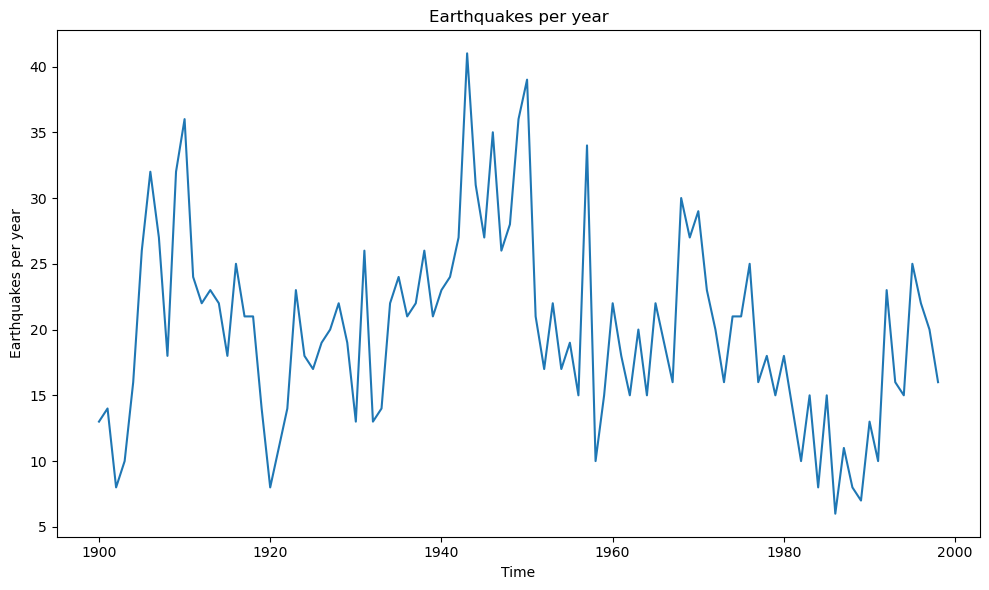

In [7]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['earthquakes_per_year'])
plt.title('Earthquakes per year')

plt.xlabel('Time')
plt.ylabel('Earthquakes per year')

plt.tight_layout()
plt.show()

In [8]:
ADF_result = adfuller(df['earthquakes_per_year'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -3.183192251191782
p-value: 0.02097842525600371


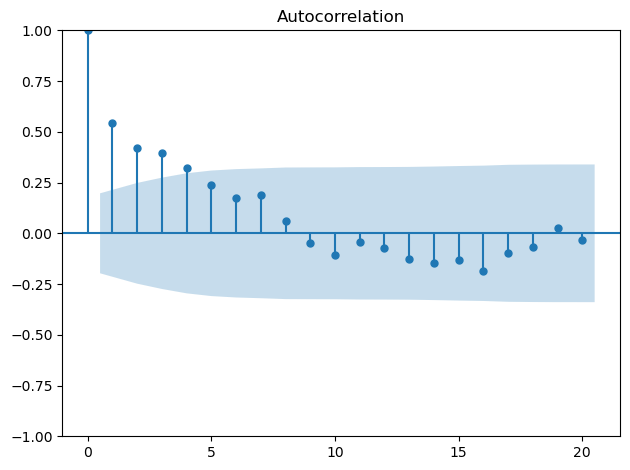

In [9]:
plot_acf(df['earthquakes_per_year']);

plt.tight_layout()

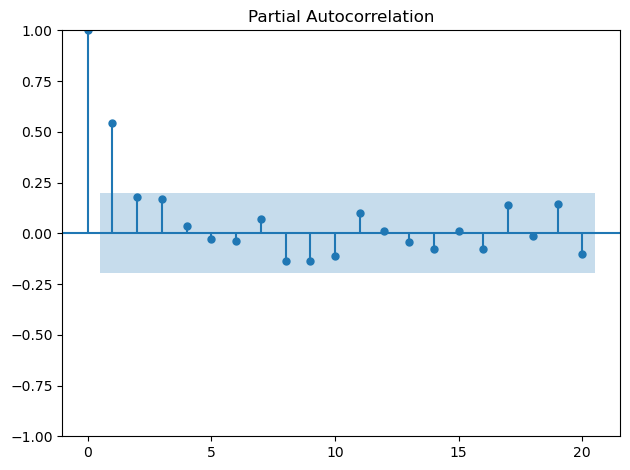

In [10]:
plot_pacf(df['earthquakes_per_year'])
plt.tight_layout()

In [11]:
train = df[:int(0.9*len(df))]
test = df[int(0.9*len(df)):]


print(len(train))
print(len(test))

89
10


In [12]:
TRAIN_LEN = len(train)
HORIZON = len(test)

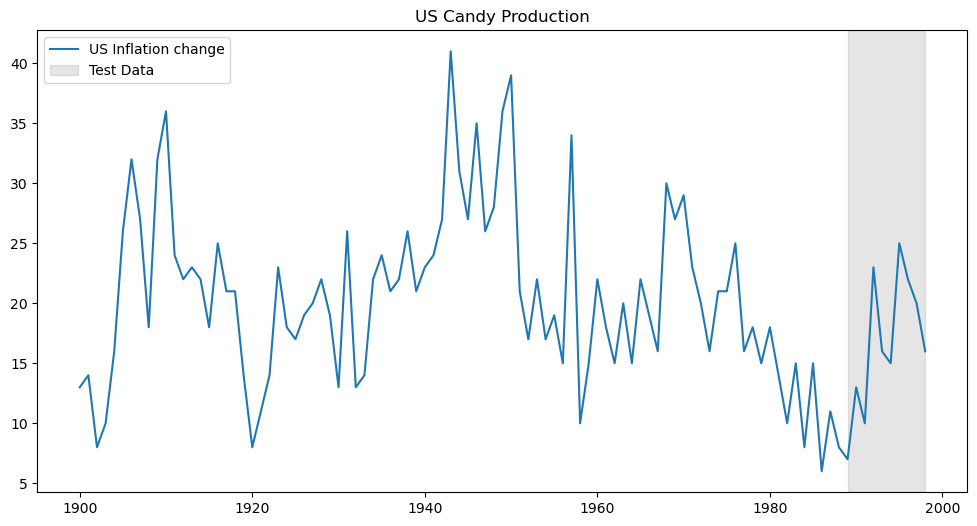

In [13]:
test_start = df.index[TRAIN_LEN]  # Start of the test data
test_end = df.index[-1]  # End of the test data


# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['earthquakes_per_year'], label='US Inflation change')

# Highlight the test data range
plt.axvspan(test_start, test_end, color='#808080', alpha=0.2, label="Test Data")

plt.title('US Candy Production')
plt.legend()
plt.show()

In [ ]:

def optimize_ARMA(endog: pd.Series, p_range: list, q_range: list) -> pd.DataFrame:
    results = []

    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(endog, order=(p, 0, q)).fit()
                aic = model.aic  # Akaike Information Criterion
                bic = model.bic  # Bayesian Information Criterion
                results.append([(p, q), aic, bic])
            except ValueError:
                continue  # Skip invalid model configurations

    result_df = pd.DataFrame(results, columns=['(p,q)', 'AIC', 'BIC'])
    return result_df.sort_values(by='AIC').reset_index(drop=True)  # Sort by lowest AIC

In [ ]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)


In [ ]:
result_df = optimize_ARMA(train, ps,qs)
result_df

In [ ]:
model = ARIMA(train, order=(3,0,2))
model_fit = model.fit()
residuals = model_fit.resid

In [ ]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = ARIMA(df[:i], order=(1,0,0))
            result = model.fit()
            predictions = result.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [15]:
pred_df = test.copy()


WINDOW = 1

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'AR')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_AR'] = pred_AR

pred_df.head()

,earthquakes_per_year,pred_mean,pred_last_value,pred_AR
date,,,,
1989-01-01,7.0,20.393258,8.0,13.518250
1990-01-01,13.0,20.244444,7.0,12.674453
1991-01-01,10.0,20.164835,13.0,16.056785
1992-01-01,23.0,20.054348,10.0,14.219635
1993-01-01,16.0,20.086022,23.0,21.672260


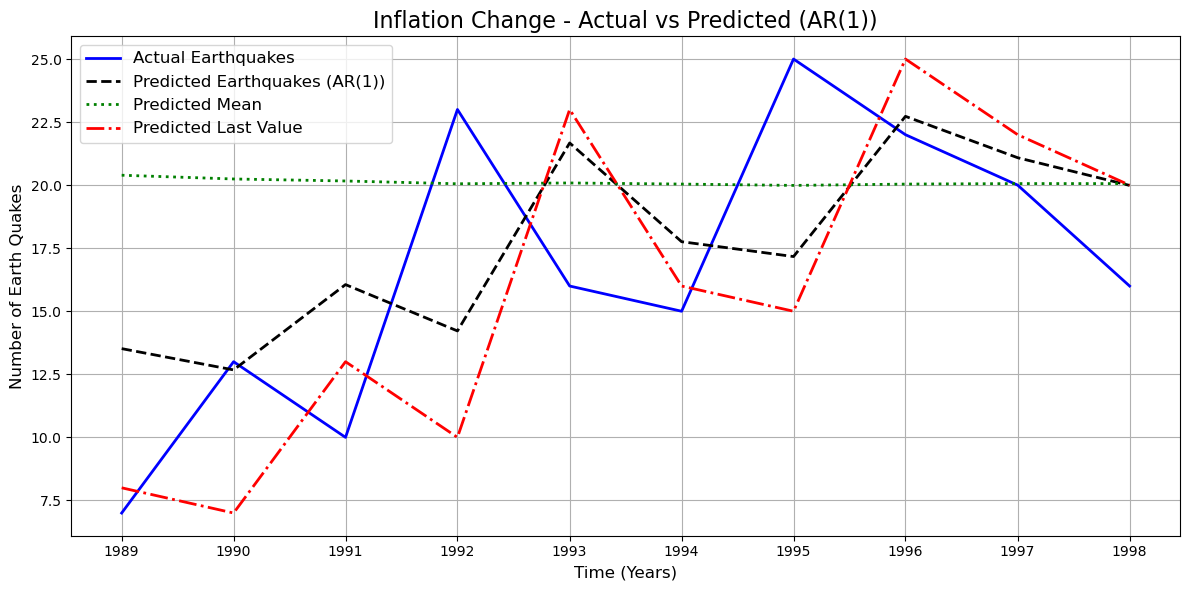

In [16]:
# Create figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))  # Increase the size for better visibility

# Plot the original inflation change data
# ax.plot(df['inflation_change'], label='Inflation Change', color='orange', linewidth=2)

# Plot the actual inflation change values from pred_df
ax.plot(pred_df['earthquakes_per_year'], 'b-', label='Actual Earthquakes', linewidth=2)

# Plot the predicted values based on MA(1) model from pred_df
ax.plot(pred_df['pred_AR'], 'k--', label='Predicted Earthquakes (AR(1))', linewidth=2)

# Optional: Plot other predictions (e.g., mean or last value) if desired
ax.plot(pred_df['pred_mean'], 'g:', label='Predicted Mean', linewidth=2)
ax.plot(pred_df['pred_last_value'], 'r-.', label='Predicted Last Value', linewidth=2)

# Adding title and labels to make the plot more readable
ax.set_title('Inflation Change - Actual vs Predicted (AR(1))', fontsize=16)
ax.set_xlabel('Time (Years)', fontsize=12)
ax.set_ylabel('Number of Earth Quakes', fontsize=12)

# Adding a legend to distinguish between the different series
ax.legend(loc='upper left', fontsize=12)

# Optional: Grid for better readability
ax.grid(True)

# Show the plot
plt.tight_layout()  # To make sure everything fits nicely in the figure
plt.show()


In [17]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['earthquakes_per_year'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['earthquakes_per_year'], pred_df['pred_last_value'])
mse_AR = mean_squared_error(pred_df['earthquakes_per_year'], pred_df['pred_AR'])

print(mse_mean, mse_last, mse_AR)

43.14228155755964 39.4 27.511222133586948


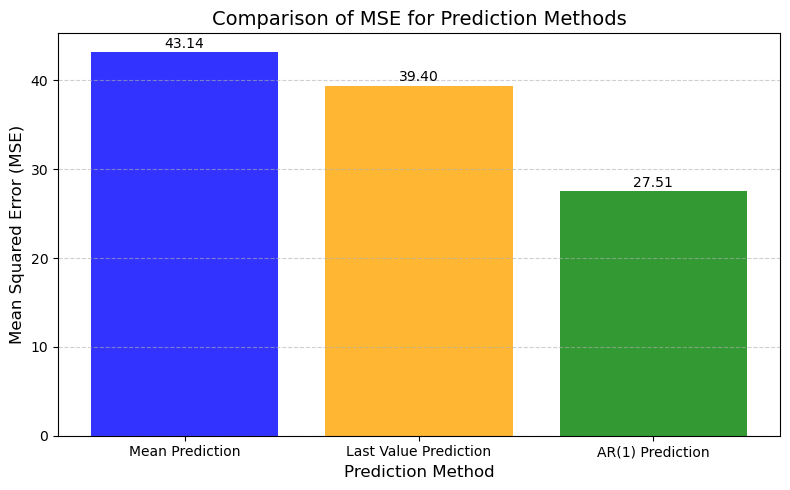

In [18]:
# MSE values

# Store in a list
mse_values = [mse_mean, mse_last, mse_AR]

methods = ['Mean Prediction', 'Last Value Prediction', 'AR(1) Prediction']

# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(methods, mse_values, color=['blue', 'orange', 'green'], alpha=0.8)

# Add value annotations on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f'{yval:.2f}', ha='center', fontsize=10)

# Set labels and title
ax.set_xlabel('Prediction Method', fontsize=12)
ax.set_ylabel('Mean Squared Error (MSE)', fontsize=12)
ax.set_title('Comparison of MSE for Prediction Methods', fontsize=14)

# Add gridlines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()